In [8]:
import polars as pl
from statsmodels.api import OLS
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import sys


In [9]:
df = pl.read_parquet('..\\data\\candle_data.parquet').sort(by='tradetime')
close_std = df['close'].std()

In [10]:
df.head()

shape: (5, 8)
┌──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬──────────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ close    ┆ volume    ┆ tradetime    ┆ product_id │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---          ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ datetime[μs] ┆ str        │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪══════════════╪════════════╡
│ 1.7148e9 ┆ 62660.77 ┆ 62722.37 ┆ 62670.66 ┆ 62706.76 ┆ 16.753435 ┆ 2024-05-04   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 02:55:00     ┆            │
│ 1.7148e9 ┆ 62694.33 ┆ 62730.71 ┆ 62706.77 ┆ 62712.68 ┆ 32.602443 ┆ 2024-05-04   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 03:00:00     ┆            │
│ 1.7148e9 ┆ 62686.01 ┆ 62809.38 ┆ 62712.68 ┆ 62770.0  ┆ 36.961407 ┆ 2024-05-04   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 03:05:00     ┆            │
│ 1.7148e9 ┆ 62713.39 ┆ 62770.0  ┆ 62770.0  ┆ 62720.0  ┆ 18.81329  ┆ 2024-05-04   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 03:10:00     ┆            │
│ 1.7148e9 ┆ 62714.01 ┆ 62742.36 ┆ 62720.0  ┆ 62742.36 ┆ 51.552387 ┆ 2024-05-04   ┆ BTC-USD    │
│          ┆          ┆          ┆          ┆          ┆           ┆ 03:15:00     ┆            │
└──────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────────┴────────────┘

In [11]:
def linear_regression(df, x_col, y_col):
  """
  Performs linear regression on a Polars DataFrame.

  Args:
      df: The Polars DataFrame containing data.
      x_col: The column name for the independent variable (e.g., lagged price).
      y_col: The column name for the dependent variable (current close price).

  Returns:
      A statsmodels.api.OLS fitted model object.
  """
  model = OLS.from_formula(f"{y_col} ~ {x_col}", data=df)
  return model.fit()

In [12]:
lag = 70
model = linear_regression(df, f"close.shift({lag})", "close")
num_std = 1.5

In [13]:
# Extract slope and intercept from the fitted model
slope = model.params[f'close.shift({lag})']
intercept = model.params["Intercept"]

# Calculate standard deviation of residuals
std_dev = model.resid.std()

# Add new columns for upper and lower bands
df = df.with_columns(
    upper_band = df["close"].shift(lag) * slope + intercept + (num_std * std_dev))

df = df.with_columns(
    lower_band = df["close"].shift(lag) * slope + intercept - (num_std * std_dev))

df = df.with_columns(
    regline = df['close'].shift(lag) * slope + intercept
)

In [14]:
df.shape

(4320, 11)

In [15]:
df.head()

shape: (5, 11)
┌──────────┬──────────┬──────────┬──────────┬───┬────────────┬────────────┬────────────┬─────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ product_id ┆ upper_band ┆ lower_band ┆ regline │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---     │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ str        ┆ f64        ┆ f64        ┆ f64     │
╞══════════╪══════════╪══════════╪══════════╪═══╪════════════╪════════════╪════════════╪═════════╡
│ 1.7148e9 ┆ 62660.77 ┆ 62722.37 ┆ 62670.66 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7148e9 ┆ 62694.33 ┆ 62730.71 ┆ 62706.77 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7148e9 ┆ 62686.01 ┆ 62809.38 ┆ 62712.68 ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7148e9 ┆ 62713.39 ┆ 62770.0  ┆ 62770.0  ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
│ 1.7148e9 ┆ 62714.01 ┆ 62742.36 ┆ 62720.0  ┆ … ┆ BTC-USD    ┆ null       ┆ null       ┆ null    │
└──────────┴──────────┴──────────┴──────────┴───┴────────────┴────────────┴────────────┴─────────┘

In [16]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))

fig.add_trace(
    go.Scatter(
        x=df["tradetime"],
        y=df["lower_band"],
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Premium",
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=df["tradetime"],
        y=df["upper_band"],
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Upper Band Fill",
        showlegend=False,
    )
)

# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

In [17]:
dfs = df.with_columns(signal = pl.lit('hold'))
dfs = dfs.with_columns(prev_close = pl.col('close').shift())

dfs = dfs.with_columns(
        signal = pl.when((pl.col('close') > pl.col('upper_band')) & (pl.col('prev_close') < pl.col('upper_band')))
        .then(pl.lit('sell'))
        .otherwise(pl.col('signal'))
    )

dfs = dfs.with_columns(
        signal = pl.when((pl.col('close') < pl.col('lower_band')) & (pl.col('prev_close') > pl.col('lower_band')))
        .then(pl.lit('buy'))
        .otherwise(pl.col('signal'))
    )



In [18]:
signals_df = dfs.filter(pl.col('signal') != 'hold')
signals_df.head()

shape: (5, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────────┬─────────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band   ┆ regline     ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---          ┆ ---         ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64          ┆ f64         ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════════╪═════════════╪════════╪════════════╡
│ 1.7148e9 ┆ 64007.11 ┆ 64488.97 ┆ 64066.79 ┆ … ┆ 62114.321852 ┆ 63138.16030 ┆ sell   ┆ 64061.59   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7148e9 ┆ 64182.01 ┆ 64377.82 ┆ 64197.02 ┆ … ┆ 62192.840398 ┆ 63216.67885 ┆ sell   ┆ 64197.01   │
│ 1.7148e9 ┆ 63874.08 ┆ 64121.65 ┆ 63923.38 ┆ … ┆ 61997.686944 ┆ 63021.52539 ┆ sell   ┆ 63922.9    │
│          ┆          ┆          ┆          ┆   ┆              ┆ 6           ┆        ┆            │
│ 1.7150e9 ┆ 65052.4  ┆ 65500.0  ┆ 65052.81 ┆ … ┆ 63106.552842 ┆ 64130.39129 ┆ sell   ┆ 65045.66   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 4           ┆        ┆            │
│ 1.7150e9 ┆ 62994.37 ┆ 63363.97 ┆ 63311.61 ┆ … ┆ 63100.23548  ┆ 64124.07393 ┆ buy    ┆ 63311.61   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 1           ┆        ┆            │
└──────────┴──────────┴──────────┴──────────┴───┴──────────────┴─────────────┴────────┴────────────┘

In [19]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))


def color_map(val):
    if val == 'buy':
        return 'green'
    elif val == 'sell':
        return 'red'
    else:
        return 'gray'

fig.add_trace(
    go.Scatter(x=signals_df['tradetime'],
                y = signals_df['close'],
                mode="markers", 
                customdata=signals_df['signal'],
                marker=dict(color=[color_map(val) for val in signals_df['signal']]),
                name = 'BUY/SELL Signal'
                )
            )


# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

In [20]:
# Show strategy outcome
initial_amount = 10000.00 # Principal in dollars ($)
balance = initial_amount
n_assets = 0 # start with 0 assets 

In [21]:
dfs.head()

shape: (5, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬────────────┬─────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band ┆ regline ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---     ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64        ┆ f64     ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪════════════╪═════════╪════════╪════════════╡
│ 1.7148e9 ┆ 62660.77 ┆ 62722.37 ┆ 62670.66 ┆ … ┆ null       ┆ null    ┆ hold   ┆ null       │
│ 1.7148e9 ┆ 62694.33 ┆ 62730.71 ┆ 62706.77 ┆ … ┆ null       ┆ null    ┆ hold   ┆ 62706.76   │
│ 1.7148e9 ┆ 62686.01 ┆ 62809.38 ┆ 62712.68 ┆ … ┆ null       ┆ null    ┆ hold   ┆ 62712.68   │
│ 1.7148e9 ┆ 62713.39 ┆ 62770.0  ┆ 62770.0  ┆ … ┆ null       ┆ null    ┆ hold   ┆ 62770.0    │
│ 1.7148e9 ┆ 62714.01 ┆ 62742.36 ┆ 62720.0  ┆ … ┆ null       ┆ null    ┆ hold   ┆ 62720.0    │
└──────────┴──────────┴──────────┴──────────┴───┴────────────┴─────────┴────────┴────────────┘

In [22]:
timeline_df = dfs.select(pl.col('tradetime'), pl.col('close'), pl.col('signal')).to_pandas().sort_values(by = 'tradetime')
timeline_df.shape


(4320, 3)

In [23]:
timeline_df

tradetime     close signal
0    2024-05-04 02:55:00  62706.76   hold
1    2024-05-04 03:00:00  62712.68   hold
2    2024-05-04 03:05:00  62770.00   hold
3    2024-05-04 03:10:00  62720.00   hold
4    2024-05-04 03:15:00  62742.36   hold
...                  ...       ...    ...
4315 2024-05-19 02:30:00  66994.21   hold
4316 2024-05-19 02:35:00  66993.26   hold
4317 2024-05-19 02:40:00  67012.86   hold
4318 2024-05-19 02:45:00  67128.58   hold
4319 2024-05-19 02:50:00  67145.35   hold

[4320 rows x 3 columns]

In [24]:
# implement trade logic on signals

trade_log = {}
for idx, row in timeline_df.iterrows():
    signal = row['signal']
    close = row['close']
    tradetime = row['tradetime']

    if (signal == 'buy') & (balance > 0):       
        n_assets = balance / close 
        balance -= n_assets * close

        trade_log[tradetime] = ['buy', close, n_assets, balance]

    elif (signal == 'sell') & (n_assets > 0):
        balance = n_assets * close
        n_assets = 0
        trade_log[tradetime] = ['sell', close, n_assets, balance]

    else:
        next 

if list(trade_log.values())[-1][0] == 'buy':
    trade_log[tradetime] = ['sell', close, 0, n_assets * close]

In [25]:
trades = (
    pd.DataFrame.from_dict(
        trade_log, orient="index", columns=["action", "price", "quantity", "balance"]
    )
    .reset_index()
    .rename(columns={"index": "tradetime"})
)

In [26]:
final_balance = trades.tail(1)['balance']

trading_return = (final_balance - initial_amount) / initial_amount * 100

In [42]:
print(f'Trading return: {trading_return.values[0]:.2f}%')

Trading return: 5.26%


<Axes: xlabel='tradetime'>

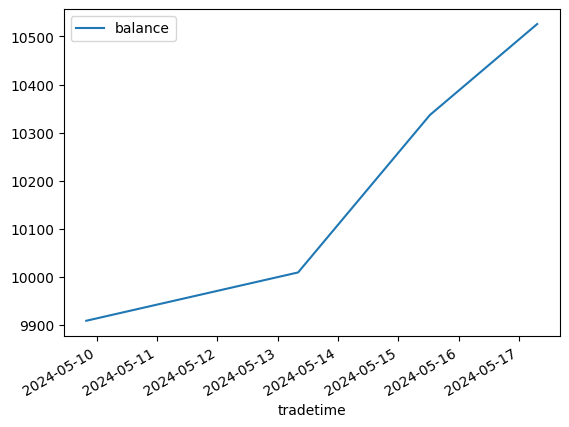

In [28]:
trades[trades['balance'] > 0].plot(x='tradetime',y='balance')

In [29]:
trades[trades['balance'] > 0]['balance'].mean()

10195.25544408136

In [30]:
dfs2 = df.with_columns(signal = pl.lit('hold'))
dfs2 = dfs2.with_columns(prev_close = pl.col('close').shift())

dfs2 = dfs2.with_columns(
        signal = pl.when((pl.col('close') > pl.col('upper_band')) & (pl.col('prev_close') < pl.col('upper_band')))
        .then(pl.lit('sell'))
        .otherwise(pl.col('signal'))
    )

dfs2 = dfs2.with_columns(
        signal = pl.when((pl.col('close') < pl.col('lower_band')) & (pl.col('prev_close') > pl.col('lower_band')))
        .then(pl.lit('buy'))
        .otherwise(pl.col('signal'))
    )

In [31]:
dfs2

shape: (4_320, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────────┬─────────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band   ┆ regline     ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---          ┆ ---         ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64          ┆ f64         ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════════╪═════════════╪════════╪════════════╡
│ 1.7148e9 ┆ 62660.77 ┆ 62722.37 ┆ 62670.66 ┆ … ┆ null         ┆ null        ┆ hold   ┆ null       │
│ 1.7148e9 ┆ 62694.33 ┆ 62730.71 ┆ 62706.77 ┆ … ┆ null         ┆ null        ┆ hold   ┆ 62706.76   │
│ 1.7148e9 ┆ 62686.01 ┆ 62809.38 ┆ 62712.68 ┆ … ┆ null         ┆ null        ┆ hold   ┆ 62712.68   │
│ 1.7148e9 ┆ 62713.39 ┆ 62770.0  ┆ 62770.0  ┆ … ┆ null         ┆ null        ┆ hold   ┆ 62770.0    │
│ 1.7148e9 ┆ 62714.01 ┆ 62742.36 ┆ 62720.0  ┆ … ┆ null         ┆ null        ┆ hold   ┆ 62720.0    │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …            ┆ …           ┆ …      ┆ …          │
│ 1.7161e9 ┆ 66971.94 ┆ 67072.32 ┆ 67069.57 ┆ … ┆ 65931.812366 ┆ 66955.65081 ┆ hold   ┆ 67068.18   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 8           ┆        ┆            │
│ 1.7161e9 ┆ 66953.73 ┆ 66997.89 ┆ 66994.21 ┆ … ┆ 65931.349414 ┆ 66955.18786 ┆ hold   ┆ 66994.21   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 6           ┆        ┆            │
│ 1.7161e9 ┆ 66990.68 ┆ 67030.3  ┆ 66990.68 ┆ … ┆ 65899.637219 ┆ 66923.47567 ┆ hold   ┆ 66993.26   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 1           ┆        ┆            │
│ 1.7161e9 ┆ 67012.85 ┆ 67175.99 ┆ 67012.86 ┆ … ┆ 65902.501733 ┆ 66926.34018 ┆ hold   ┆ 67012.86   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 5           ┆        ┆            │
│ 1.7161e9 ┆ 67121.94 ┆ 67196.89 ┆ 67128.59 ┆ … ┆ 65895.055926 ┆ 66918.89437 ┆ hold   ┆ 67128.58   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 7           ┆        ┆            │
└──────────┴──────────┴──────────┴──────────┴───┴──────────────┴─────────────┴────────┴────────────┘

In [32]:
signals_df2 = dfs2.filter(pl.col('signal') != 'hold')
signals_df2

shape: (29, 13)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────────┬─────────────┬────────┬────────────┐
│ time     ┆ low      ┆ high     ┆ open     ┆ … ┆ lower_band   ┆ regline     ┆ signal ┆ prev_close │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---          ┆ ---         ┆ ---    ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64          ┆ f64         ┆ str    ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════════╪═════════════╪════════╪════════════╡
│ 1.7148e9 ┆ 64007.11 ┆ 64488.97 ┆ 64066.79 ┆ … ┆ 62114.321852 ┆ 63138.16030 ┆ sell   ┆ 64061.59   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7148e9 ┆ 64182.01 ┆ 64377.82 ┆ 64197.02 ┆ … ┆ 62192.840398 ┆ 63216.67885 ┆ sell   ┆ 64197.01   │
│ 1.7148e9 ┆ 63874.08 ┆ 64121.65 ┆ 63923.38 ┆ … ┆ 61997.686944 ┆ 63021.52539 ┆ sell   ┆ 63922.9    │
│          ┆          ┆          ┆          ┆   ┆              ┆ 6           ┆        ┆            │
│ 1.7150e9 ┆ 65052.4  ┆ 65500.0  ┆ 65052.81 ┆ … ┆ 63106.552842 ┆ 64130.39129 ┆ sell   ┆ 65045.66   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 4           ┆        ┆            │
│ 1.7150e9 ┆ 62994.37 ┆ 63363.97 ┆ 63311.61 ┆ … ┆ 63100.23548  ┆ 64124.07393 ┆ buy    ┆ 63311.61   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 1           ┆        ┆            │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …            ┆ …           ┆ …      ┆ …          │
│ 1.7159e9 ┆ 64915.62 ┆ 65194.67 ┆ 65140.52 ┆ … ┆ 65128.388532 ┆ 66152.22698 ┆ buy    ┆ 65141.46   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 4           ┆        ┆            │
│ 1.7159e9 ┆ 66114.14 ┆ 66363.06 ┆ 66118.41 ┆ … ┆ 64137.613911 ┆ 65161.45236 ┆ sell   ┆ 66121.15   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
│ 1.7159e9 ┆ 66182.85 ┆ 66258.07 ┆ 66233.61 ┆ … ┆ 64202.060653 ┆ 65225.89910 ┆ sell   ┆ 66233.61   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 5           ┆        ┆            │
│ 1.7160e9 ┆ 67070.01 ┆ 67445.45 ┆ 67096.68 ┆ … ┆ 65204.881665 ┆ 66228.72011 ┆ sell   ┆ 67096.67   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 6           ┆        ┆            │
│ 1.7160e9 ┆ 66850.01 ┆ 66957.57 ┆ 66923.4  ┆ … ┆ 64883.139841 ┆ 65906.97829 ┆ sell   ┆ 66923.39   │
│          ┆          ┆          ┆          ┆   ┆              ┆ 3           ┆        ┆            │
└──────────┴──────────┴──────────┴──────────┴───┴──────────────┴─────────────┴────────┴────────────┘

In [33]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))


def color_map(val):
    if val == 'buy':
        return 'green'
    elif val == 'sell':
        return 'red'
    else:
        return 'gray'

fig.add_trace(
    go.Scatter(x=signals_df2['tradetime'],
                y = signals_df2['close'],
                mode="markers", 
                customdata=signals_df['signal'],
                marker=dict(color=[color_map(val) for val in signals_df2['signal']]),
                name = 'BUY/SELL Signal'
                )
            )


# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()